<a href="https://www.kaggle.com/code/evelinewasonga/bank-transactions-eda?scriptVersionId=279900465" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/kaggle/input/transactions-fraud-datasets/transactions_data.csv")
df.head(5)

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [3]:
df.dtypes

id                  int64
date               object
client_id           int64
card_id             int64
amount             object
use_chip           object
merchant_id         int64
merchant_city      object
merchant_state     object
zip               float64
mcc                 int64
errors             object
dtype: object

In [4]:
df["amount"] = (
    df["amount"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
    .str.replace(" ", "", regex=False)
    .str.replace(r"(.∗)(.*)", r"-\1", regex=True)
    .astype(float)
)

In [5]:
import numpy as np

# 1. Ensure 'date' is datetime (coerce invalid strings to NaT)
df['date'] = pd.to_datetime(df['date'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

# Optional: check for any NaT values after conversion
if df['date'].isna().any():
    print("Warning: some dates could not be parsed. Count:", df['date'].isna().sum())

# 2. Basic splits
df['transaction_date'] = df['date'].dt.date                # python date object
df['transaction_time'] = df['date'].dt.time                # python time object

# 3. Numeric/time parts (fast for grouping/aggregations)
df['year'] = df['date'].dt.year.astype('int16')           # 2010-2019 -> int16
df['month'] = df['date'].dt.month.astype('uint8')         # 1-12
df['day'] = df['date'].dt.day.astype('uint8')             # 1-31
df['hour'] = df['date'].dt.hour.astype('uint8')           # 0-23
df['minute'] = df['date'].dt.minute.astype('uint8')       # 0-59

# 4. Weekday as string and numeric
df['weekday'] = df['date'].dt.day_name().astype('category')  
df['weekday_num'] = df['date'].dt.weekday.astype('uint8') # Monday=0 .. Sunday=6

# 5. ISO week / quarter
iso = df['date'].dt.isocalendar()                        
df['iso_year'] = iso['year'].astype('int16')             
df['iso_week'] = iso['week'].astype('uint8')             
df['quarter'] = df['date'].dt.quarter.astype('uint8')    

# 6. Weekend flag
df['is_weekend'] = (df['weekday_num'] >= 5).astype('uint8')  # 1 if Sat/Sun

# 7. Quick sanity check
print("Sample derived features:")
display(df.loc[:, ['date','transaction_date','transaction_time',
                   'year','month','day','hour','weekday','is_weekend']].head(6))

Sample derived features:


,date,transaction_date,transaction_time,year,month,day,hour,weekday,is_weekend
0,2010-01-01 00:01:00,2010-01-01,00:01:00,2010,1,1,0,Friday,0
1,2010-01-01 00:02:00,2010-01-01,00:02:00,2010,1,1,0,Friday,0
2,2010-01-01 00:02:00,2010-01-01,00:02:00,2010,1,1,0,Friday,0
3,2010-01-01 00:05:00,2010-01-01,00:05:00,2010,1,1,0,Friday,0
4,2010-01-01 00:06:00,2010-01-01,00:06:00,2010,1,1,0,Friday,0
5,2010-01-01 00:07:00,2010-01-01,00:07:00,2010,1,1,0,Friday,0


In [6]:
print(df['amount'].describe())

count    1.330592e+07
mean     4.297604e+01
std      8.165575e+01
min     -5.000000e+02
25%      8.930000e+00
50%      2.899000e+01
75%      6.371000e+01
max      6.820200e+03
Name: amount, dtype: float64


In [7]:
df['merchant_state'] = df['merchant_state'].fillna("UNKNOWN")

In [9]:
df['zip'] = (
    df['zip']
    .astype(str)
    .str.extract(r'(\d+)')[0]   # select the first column from extract
    .astype('Int64')            # convert to nullable integer
    .astype(str)                # back to string
    .str.zfill(5)               # pad with leading zeros to length 5
)

In [10]:
df['merchant_city'].value_counts().head(10)
df['merchant_state'].value_counts().head(10)
df['merchant_id'].value_counts().head(10)
# Identify hotspots

merchant_id
59935    610053
27092    589140
61195    562410
39021    440281
43293    362842
22204    347511
14528    333505
60569    301657
50783    298231
75781    273351
Name: count, dtype: int64

In [11]:
df['use_chip'].value_counts()
# Detect any fraud in swipe and online

use_chip
Swipe Transaction     6967185
Chip Transaction      4780818
Online Transaction    1557912
Name: count, dtype: int64

In [12]:
df[df['use_chip'] == 'Online Transaction']['errors'].value_counts().head(10)
# Online transactions with errors: insufficient balance, declined, fraud

errors
Insufficient Balance                    12160
Bad Card Number                          7766
Bad Expiration                           6161
Bad CVV                                  6103
Technical Glitch                         3024
Bad Card Number,Insufficient Balance       70
Bad CVV,Insufficient Balance               57
Bad Expiration,Insufficient Balance        47
Bad Card Number,Bad CVV                    38
Bad Card Number,Bad Expiration             33
Name: count, dtype: int64

In [13]:
df[(df['use_chip'] == 'Swipe Transaction') & (df['amount'] > 500)].sort_values('amount', ascending=False).head(20)
# Swipe transactions with high amount

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,month,day,hour,minute,weekday,weekday_num,iso_year,iso_week,quarter,is_weekend
892174,8544734,2010-09-22 06:37:00,708,5165,6820.20,Swipe Transaction,34524,Staten Island,NY,10302,...,9,22,6,37,Wednesday,2,2010,38,3,0
2888921,10973185,2012-04-10 11:05:00,1259,5406,5913.37,Swipe Transaction,85983,Wilton,CT,06897,...,4,10,11,5,Tuesday,1,2012,15,2,0
6388103,15245857,2014-11-13 10:27:00,1259,5406,5654.50,Swipe Transaction,76639,Stamford,CT,06907,...,11,13,10,27,Thursday,3,2014,46,4,0
5793720,14517073,2014-06-07 11:06:00,1259,2006,4747.97,Swipe Transaction,84905,Wilton,CT,06897,...,6,7,11,6,Saturday,5,2014,23,2,1
1813332,9662810,2011-06-13 14:24:00,96,3773,4685.23,Swipe Transaction,81591,Yorba Linda,CA,92886,...,6,13,14,24,Monday,0,2011,24,2,0
3841748,12133889,2012-12-28 16:10:00,1811,291,4175.85,Swipe Transaction,59223,Menlo Park,CA,94025,...,12,28,16,10,Friday,4,2012,52,4,0
177166,7686947,2010-02-23 15:22:00,776,5859,4004.73,Swipe Transaction,76639,Memphis,TN,38107,...,2,23,15,22,Tuesday,1,2010,8,1,0
6052501,14834251,2014-08-15 14:13:00,96,5175,3732.84,Swipe Transaction,60569,Santa Barbara,CA,93101,...,8,15,14,13,Friday,4,2014,33,3,0
603507,8197899,2010-06-30 10:48:00,708,5165,3424.51,Swipe Transaction,80871,Philadelphia,PA,19114,...,6,30,10,48,Wednesday,2,2010,26,2,0
6007680,14779124,2014-08-03 14:01:00,708,281,3380.98,Swipe Transaction,38489,Elmhurst,NY,11373,...,8,3,14,1,Sunday,6,2014,31,3,1


In [14]:
df.groupby(['client_id', 'use_chip'])['errors'].apply(lambda x: (x != '').sum()).sort_values(ascending=False).head(10)
# Multiple failed attempts before success: fraud flag

client_id  use_chip         
1098       Swipe Transaction    24356
           Chip Transaction     23725
96         Swipe Transaction    23226
909        Swipe Transaction    21460
1459       Swipe Transaction    21061
285        Swipe Transaction    20976
1888       Swipe Transaction    20741
1963       Swipe Transaction    19399
502        Swipe Transaction    19131
1888       Chip Transaction     18881
Name: errors, dtype: int64

In [15]:
df[df['errors'] != ''].groupby('merchant_id')['errors'].count().sort_values(ascending=False).head(10)
# Merchants with unusually high declines

merchant_id
27092    18206
59935    11417
39021     8992
61195     8743
60569     6306
43293     6070
22204     6052
26810     3491
20561     3429
50783     3395
Name: errors, dtype: int64

In [16]:
failed_attempts = (
    df[df['errors'] != '']
    .groupby('client_id')['errors']
    .count()
    .sort_values(ascending=False)
    .head(10)
)

failed_attempts
# Top 10 clients with frequent declines, insufficient balance, fraud flags, etc

client_id
954     2935
1888    2109
464     1196
1098    1125
1696     953
425      847
1424     822
1382     821
373      816
114      796
Name: errors, dtype: int64

In [17]:
# create full datetime without copying
df['full_datetime'] = pd.to_datetime(
    df['transaction_date'].astype(str) + ' ' + df['transaction_time'].astype(str)
)

# keep only needed columns to reduce memory
cols = ['client_id', 'merchant_state', 'full_datetime']
df_small = df[cols]

# sort only the small df
df_small = df_small.sort_values(['client_id', 'full_datetime'])

df_small['prev_state'] = df_small.groupby('client_id')['merchant_state'].shift()
df_small['prev_time'] = df_small.groupby('client_id')['full_datetime'].shift()

df_small['time_diff'] = df_small['full_datetime'] - df_small['prev_time']

suspicious_travel = df_small[
    (df_small['merchant_state'] != df_small['prev_state']) &
    (df_small['time_diff'].dt.total_seconds() < 1800)
]

suspicious_travel.head()
# Same client spending in different states within 30 minutes

,client_id,merchant_state,full_datetime,prev_state,prev_time,time_diff
11584,0,ME,2010-01-04 13:19:00,UNKNOWN,2010-01-04 13:03:00,0 days 00:16:00
28007,0,MA,2010-01-09 14:50:00,NV,2010-01-09 14:36:00,0 days 00:14:00
146412,0,UNKNOWN,2010-02-14 13:05:00,ME,2010-02-14 12:49:00,0 days 00:16:00
244142,0,MI,2010-03-15 19:25:00,UNKNOWN,2010-03-15 19:23:00,0 days 00:02:00
256330,0,ME,2010-03-19 13:51:00,MI,2010-03-19 13:42:00,0 days 00:09:00


In [18]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract weekday and hour
df['weekday'] = df['date'].dt.day_name()
df['hour'] = df['date'].dt.hour

# Build pivot heatmap-friendly table
pivot = df.pivot_table(
    index='weekday',
    columns='hour',
    values='id',
    aggfunc='count'
).fillna(0)

pivot.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
weekday,,,,,,,,,,,,,,,,,,,,,
Friday,20243,16439,15938,14831,16352,26252,107709,128098,125653,125371,...,127156,122440,123178,68766,67605,65097,60460,60485,59130,22245
Monday,19883,16397,16113,14598,16475,25913,107556,128175,124947,124357,...,126793,122635,123667,69223,67822,65728,60728,60758,60239,22755
Saturday,20100,16598,16067,14901,16198,26323,108520,128340,125829,124890,...,127491,122475,123640,69342,67415,65457,60520,60797,59979,22838
Sunday,19998,16559,16034,14827,16564,26206,108354,128245,125347,125221,...,126166,122097,124167,68866,67394,65241,60536,60804,59845,22887
Thursday,19978,16578,16330,14934,16698,26340,110859,131713,127966,126941,...,127155,122996,123668,68704,67577,65300,60379,60479,59795,23002


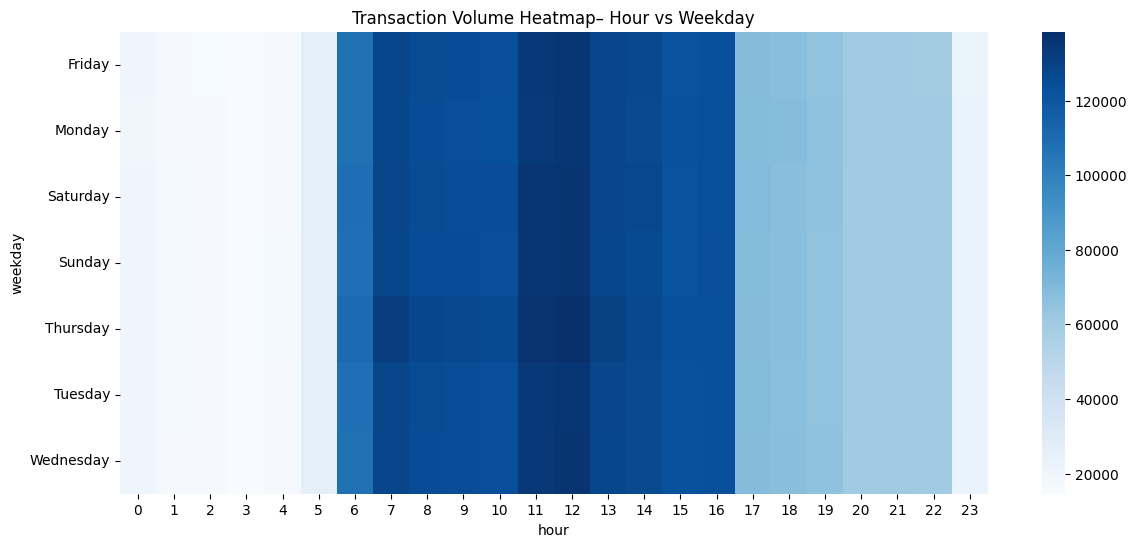

In [19]:
plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap="Blues")
plt.title("Transaction Volume Heatmap– Hour vs Weekday")
plt.show()

In [20]:
hourly = df.pivot_table(
    index='hour',
    columns='use_chip',
    values='id',
    aggfunc='count'
).fillna(0)

hourly

use_chip,Chip Transaction,Online Transaction,Swipe Transaction
hour,,,
0,45130,29960,65492
1,39627,21651,54308
2,38394,18528,55865
3,37144,11926,54408
4,37546,22795,54644
5,63869,25218,93878
6,277309,82772,398775
7,326774,101819,473163
8,327643,84554,468304


In [21]:
hourly_pct = hourly.div(hourly.sum(axis=1), axis=0) * 100
hourly_pct

use_chip,Chip Transaction,Online Transaction,Swipe Transaction
hour,,,
0,32.102261,21.311405,46.586334
1,34.283564,18.731507,46.984929
2,34.041157,16.427425,49.531418
3,35.895553,11.525155,52.579292
4,32.652955,19.824325,47.522720
5,34.907769,13.782964,51.309267
6,36.543033,10.907471,52.549496
7,36.237519,11.291192,52.471289
8,37.210974,9.602942,53.186084


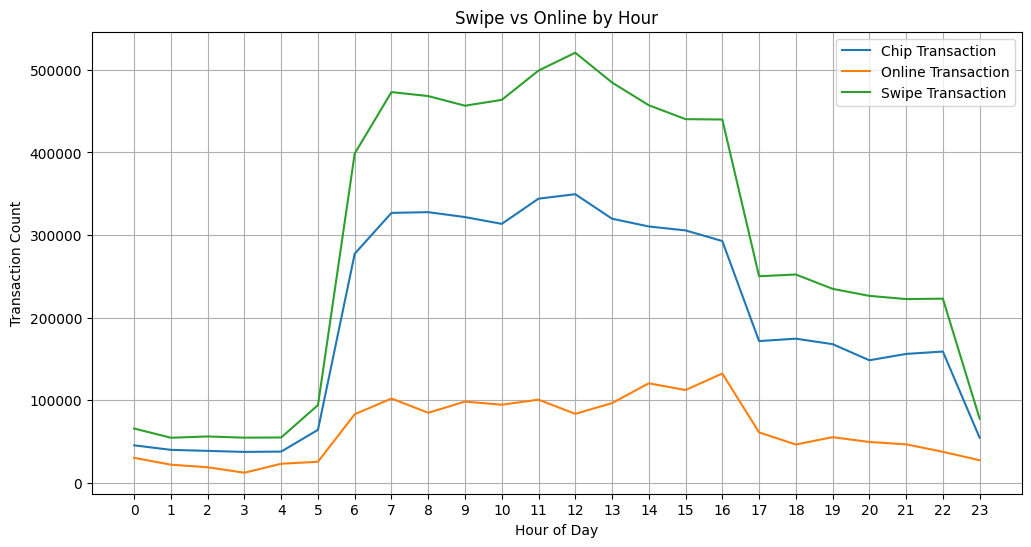

In [22]:
plt.figure(figsize=(12,6))
for method in hourly.columns:
    plt.plot(hourly.index, hourly[method], label=method)

plt.xticks(range(0,24))
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.title("Swipe vs Online by Hour")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
zip_counts = df.groupby('zip')['id'].count().sort_values(ascending=False)
zip_counts.head(20)

zip
0<NA>    1652706
98516      36753
91606      31337
87121      30679
77056      26764
55024      26478
80013      26037
95687      25722
29229      25166
30101      24425
40299      24403
43228      23382
43830      23281
94606      22842
96792      21601
11211      20710
10463      20208
92886      19534
85711      19515
48235      19098
Name: id, dtype: int64

In [24]:
df['amount_numeric'] = (
    df['amount'].astype(str)
        .str.replace('[\$,]', '', regex=True)
        .astype(float)
)

zip_stats = df.groupby('zip').agg(
    transactions=('id', 'count'),
    total_amount=('amount_numeric', 'sum'),
    avg_ticket=('amount_numeric', 'mean'),
)

zip_stats.sort_values('transactions', ascending=False).head(20)

,transactions,total_amount,avg_ticket
zip,,,
0<NA>,1652706,92232076.95,55.806705
98516,36753,562377.66,15.301544
91606,31337,631046.62,20.137429
87121,30679,594320.79,19.372235
77056,26764,758313.72,28.333348
55024,26478,776813.89,29.338088
80013,26037,820306.50,31.505415
95687,25722,783962.04,30.478269
29229,25166,519424.33,20.639924


In [25]:
refunds = df[df['amount_numeric'] < 0]
hot_refund_zips = refunds.groupby('zip')['id'].count().sort_values(ascending=False)

hot_refund_zips.head(20)

zip
0<NA>    17492
98516     8550
55024     7386
29229     6569
91606     6384
43830     6214
77056     6162
07922     5225
94606     4946
96792     4687
51022     4467
48146     4456
51023     4353
89148     4318
87121     4053
19146     3765
67212     3684
80013     3545
18011     3404
94131     3362
Name: id, dtype: int64

In [26]:
fraud_index = pd.DataFrame({
    'transactions': zip_counts,
    'refunds': hot_refund_zips
}).fillna(0)

fraud_index['refund_rate'] = fraud_index['refunds'] / fraud_index['transactions']
fraud_index.sort_values('refund_rate', ascending=False).head(20)

,transactions,refunds,refund_rate
zip,,,
53543,2,1.0,0.500000
67117,11,4.0,0.363636
54156,3,1.0,0.333333
25635,6,2.0,0.333333
41121,3,1.0,0.333333
47325,6,2.0,0.333333
75647,3,1.0,0.333333
44510,3,1.0,0.333333
66218,6,2.0,0.333333


In [28]:
import plotly.express as px
import plotly.graph_objects as go

# Ensure transaction_date is datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Aggregate by month
monthly_summary = df.groupby(df['transaction_date'].dt.to_period('M')).agg({
    'amount': 'sum',        # total transaction value
    'transaction_date': 'count'  # transaction count
}).rename(columns={'transaction_date': 'transaction_count'}).reset_index()

# Convert Period to datetime for plotting
monthly_summary['transaction_date'] = monthly_summary['transaction_date'].dt.to_timestamp()

# Line chart for total transaction value
fig_value = px.line(
    monthly_summary,
    x='transaction_date',
    y='amount',
    title='Monthly Transaction Value',
    labels={'transaction_date': 'Month', 'amount': 'Total Transaction Value'}
)
fig_value.show()

# Line chart for transaction count
fig_count = px.line(
    monthly_summary,
    x='transaction_date',
    y='transaction_count',
    title='Monthly Transaction Count',
    labels={'transaction_date': 'Month', 'transaction_count': 'Number of Transactions'}
)
fig_count.show()

In [29]:
# Ensure amount is numeric
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')

# Aggregate transaction value by customer
customer_summary = df.groupby('client_id')['amount'].sum().reset_index()

# Sort customers by transaction value descending
customer_summary = customer_summary.sort_values(by='amount', ascending=False)

# Calculate cumulative percentage of total
customer_summary['cum_percent'] = customer_summary['amount'].cumsum() / customer_summary['amount'].sum() * 100

# Pareto chart: bars for individual customer contribution, line for cumulative %
fig = go.Figure()

# Bar trace: transaction value per customer
fig.add_trace(go.Bar(
    x=customer_summary['client_id'],
    y=customer_summary['amount'],
    name='Transaction Value'
))

# Line trace: cumulative %
fig.add_trace(go.Scatter(
    x=customer_summary['client_id'],
    y=customer_summary['cum_percent'],
    name='Cumulative %',
    yaxis='y2',
    mode='lines+markers',
    line=dict(color='red', width=2)
))

# Layout with dual y-axis
fig.update_layout(
    title='Pareto Chart: Transaction Value by Customer',
    xaxis_title='Client ID',
    yaxis=dict(title='Transaction Value'),
    yaxis2=dict(title='Cumulative %', overlaying='y', side='right', range=[0, 110]),
    legend=dict(x=0.75, y=1.15)
)

fig.show()

In [31]:
import plotly.express as px

# Aggregate transaction value by state
state_summary = df.groupby('merchant_state')['amount'].sum().reset_index()

# Choropleth by US state, zoomed to USA
fig_state = px.choropleth(
    state_summary,
    locations='merchant_state',
    locationmode='USA-states',      # use US state abbreviations
    color='amount',
    color_continuous_scale='Reds',
    scope='usa',                    # zoom to USA
    title='Transaction Value by State'
)

fig_state.show()

In [32]:
# Count number of transactions per channel
channel_summary = df['use_chip'].value_counts().reset_index()
channel_summary.columns = ['channel', 'count']
# Donut chart (same as pie, but with hole in the center)
fig_donut = px.pie(
    channel_summary,
    names='channel',
    values='count',
    hole=0.4,
    title='Transaction Distribution by Channel'
)
fig_donut.show()

In [33]:
# Create approval_status based on errors column
df['approval_status'] = df['errors'].apply(lambda x: 'Rejected' if pd.notnull(x) else 'Approved')

In [34]:
# Sample preprocessing: ensure date column is datetime
df['date'] = pd.to_datetime(df['date'])

# Aggregate counts by day (or month)
approval_summary = df.groupby([df['date'].dt.to_period('M'), 'approval_status']).size().unstack(fill_value=0).reset_index()
approval_summary['date'] = approval_summary['date'].dt.to_timestamp()  # convert period to datetime

# Create waterfall chart
fig = go.Figure(go.Waterfall(
    name="Approval vs Rejection",
    x=approval_summary['date'],
    y=approval_summary['Approved'],  # Positive flow
    text=approval_summary['Approved'],
    textposition="outside",
    measure=["relative"] * len(approval_summary),  # relative for each bar
))

# Add rejected as negative values
fig.add_trace(go.Bar(
    x=approval_summary['date'],
    y=-approval_summary['Rejected'],
    name='Rejected',
    marker_color='red'
))

# Update layout
fig.update_layout(
    title="Monthly Approvals vs Rejections",
    xaxis_title="Month",
    yaxis_title="Number of Transactions",
    showlegend=True
)

fig.show()

In [35]:
# Flag anomalies
df['anomaly_high_amount'] = df['amount'].abs() > 1000          # high transaction amount
df['anomaly_high_freq'] = df.groupby('client_id')['id'].transform('count') > 20  # high frequency
df['anomaly_location'] = df['merchant_state'].isin(['ND', 'AK'])  # unusual locations (example)

# Combine anomaly flags
df['anomaly_flag'] = df[['anomaly_high_amount','anomaly_high_freq','anomaly_location']].any(axis=1)

# KPI values
total_anomalies = df['anomaly_flag'].sum()
percent_high_risk = df['anomaly_flag'].mean() * 100

# Count top reasons
reason_counts = pd.DataFrame({
    'Reason': ['High Amount', 'High Frequency', 'Unusual Location'],
    'Count': [
        df['anomaly_high_amount'].sum(),
        df['anomaly_high_freq'].sum(),
        df['anomaly_location'].sum()
    ]
})

In [37]:
# Total anomalies gauge
fig_gauge_total = go.Figure(go.Indicator(
    mode="number+gauge",
    value=total_anomalies,
    title={"text": "Total Anomalies Detected"},
    gauge={"axis": {"range": [0, df.shape[0]]}, "bar": {"color": "red"}}
))
fig_gauge_total.show()

# Percentage of high-risk transactions
fig_gauge_percent = go.Figure(go.Indicator(
    mode="gauge+number",
    value=percent_high_risk,
    title={"text": "% of High-Risk Transactions"},
    gauge={"axis": {"range": [0, 100]}, "bar": {"color": "orange"}}
))
fig_gauge_percent.show()

In [36]:
fig_bar = go.Figure(go.Bar(
    x=reason_counts['Reason'],
    y=reason_counts['Count'],
    text=reason_counts['Count'],
    textposition='auto',
    marker_color=['red', 'orange', 'purple']
))

fig_bar.update_layout(
    title="Top Reasons for Flagged Transactions",
    xaxis_title="Reason",
    yaxis_title="Number of Transactions"
)
fig_bar.show()

In [38]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. Swipe vs Online by Hour
hour_channel = df.groupby(['hour','use_chip']).size().unstack(fill_value=0).sort_index()

# detect swipe/online column names robustly
def find_col(cols, keywords):
    for kw in keywords:
        for c in cols:
            if kw.lower() in str(c).lower():
                return c
    return None

swipe_col = find_col(hour_channel.columns, ['swipe', 'chip'])      # e.g., "Swipe Transaction"
online_col = find_col(hour_channel.columns, ['online', 'web', 'e-'])  # e.g., "Online Transaction"

# 2. Transaction Volume Heatmap – Hour vs Weekday
heatmap_data = df.groupby(['weekday','hour']).size().unstack(fill_value=0)
weekdays_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
heatmap_data = heatmap_data.reindex(weekdays_order).fillna(0)

# 3. Monthly Approvals vs Rejections
approval_summary = df.groupby([df['month'], 'approval_status']).size().unstack(fill_value=0)

# 4. Transaction Distribution by Channel
channel_summary = df['use_chip'].value_counts().reset_index()
channel_summary.columns = ['channel','count']

# 5. Transaction Value by State
state_summary = df.groupby('merchant_state')['amount'].sum().reset_index()

# 6. Pareto Chart: Transaction Value by Customer
customer_summary = df.groupby('client_id')['amount'].sum().sort_values(ascending=False)
customer_summary_cumsum = (customer_summary.cumsum() / customer_summary.sum()) * 100
# keep only top N customers for readability (you can change N)
TOP_N = 50
cust_top = customer_summary.head(TOP_N)
cust_top_pct = (cust_top.cumsum() / cust_top.sum()) * 100

# 7. Monthly Transaction Value & Count
monthly_value = df.groupby('month')['amount'].sum().sort_index()
monthly_count = df.groupby('month')['id'].count().sort_index()

# --- Build subplots in the requested order ---
# Layout: 4 rows x 2 cols -> 8 charts (order follows user list)
specs = [
    [{"type":"xy"},      {"type":"heatmap"}],        # Row1: Swipe vs Online by Hour | Heatmap Hour vs Weekday
    [{"type":"bar"},     {"type":"pie"}],            # Row2: Monthly Approvals vs Rejections | Transaction Distribution by Channel
    [{"type":"choropleth"},{"type":"xy", "secondary_y": True}],  # Row3: Transaction Value by State | Pareto (secondary_y)
    [{"type":"xy"},      {"type":"xy"}]              # Row4: Monthly Transaction Value | Monthly Transaction Count
]

subplot_titles = [
    "Swipe vs Online by Hour",
    "Transaction Volume Heatmap – Hour vs Weekday",
    "Monthly Approvals vs Rejections",
    "Transaction Distribution by Channel",
    "Transaction Value by State",
    "Pareto Chart: Transaction Value by Customer",
    "Monthly Transaction Value",
    "Monthly Transaction Count"
]

fig = make_subplots(
    rows=4, cols=2,
    specs=specs,
    subplot_titles=subplot_titles,
    horizontal_spacing=0.08,
    vertical_spacing=0.08
)

# -------------------------
# Row1 Col1: Swipe vs Online by Hour (grouped bars)
# -------------------------
hours = hour_channel.index
# fallback to zero series if column not found
swipe_vals = hour_channel[swipe_col] if swipe_col in hour_channel.columns else pd.Series(0, index=hours)
online_vals = hour_channel[online_col] if online_col in hour_channel.columns else pd.Series(0, index=hours)

fig.add_trace(go.Bar(x=hours, y=swipe_vals, name=str(swipe_col or 'Swipe')), row=1, col=1)
fig.add_trace(go.Bar(x=hours, y=online_vals, name=str(online_col or 'Online')), row=1, col=1)

# -------------------------
# Row1 Col2: Transaction Volume Heatmap – Hour vs Weekday
# -------------------------
fig.add_trace(go.Heatmap(
    z=heatmap_data.values,
    x=heatmap_data.columns.astype(int),
    y=heatmap_data.index,
    colorscale='Viridis',
    colorbar=dict(title='Tx Count')
), row=1, col=2)

# -------------------------
# Row2 Col1: Monthly Approvals vs Rejections (grouped bar)
# -------------------------
# ensure index is sorted
approval_idx = approval_summary.index
approved_vals = approval_summary.get('Approved', pd.Series(0, index=approval_idx))
rejected_vals = approval_summary.get('Rejected', pd.Series(0, index=approval_idx))

fig.add_trace(go.Bar(x=approval_idx, y=approved_vals, name='Approved'), row=2, col=1)
fig.add_trace(go.Bar(x=approval_idx, y=rejected_vals, name='Rejected'), row=2, col=1)

# -------------------------
# Row2 Col2: Transaction Distribution by Channel (donut)
# -------------------------
fig.add_trace(go.Pie(labels=channel_summary['channel'], values=channel_summary['count'], hole=0.4, textinfo='percent+label'), row=2, col=2)

# -------------------------
# Row3 Col1: Transaction Value by State (choropleth)
# -------------------------
fig.add_trace(go.Choropleth(
    locations=state_summary['merchant_state'],
    locationmode='USA-states',
    z=state_summary['amount'],
    colorscale='Reds',
    colorbar=dict(title='Total Value')
), row=3, col=1)

# -------------------------
# Row3 Col2: Pareto Chart: Transaction Value by Customer (bar + cumulative line, secondary y)
# -------------------------
# Bar for top customers
fig.add_trace(go.Bar(x=cust_top.index.astype(str), y=cust_top.values, name='Transaction Value (top {})'.format(TOP_N)), row=3, col=2, secondary_y=False)
# Line for cumulative percent (mapped to secondary y)
fig.add_trace(go.Scatter(x=cust_top.index.astype(str), y=cust_top_pct.values, name='Cumulative %', mode='lines+markers'), row=3, col=2, secondary_y=True)

# -------------------------
# Row4 Col1: Monthly Transaction Value (line)
# -------------------------
fig.add_trace(go.Scatter(x=monthly_value.index, y=monthly_value.values, mode='lines+markers', name='Monthly Value'), row=4, col=1)

# -------------------------
# Row4 Col2: Monthly Transaction Count (line)
# -------------------------
fig.add_trace(go.Scatter(x=monthly_count.index, y=monthly_count.values, mode='lines+markers', name='Monthly Count'), row=4, col=2)

# -------------------------
# Layout adjustments for readability
# -------------------------
fig.update_layout(
    height=1500,
    width=2200,                # increased width for readability
    title_text="Transactions Fraud & Anomaly Dashboard",
    title_font_size=24,
    showlegend=True,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# enlarge subplot titles
for ann in fig['layout']['annotations']:
    ann['font'] = dict(size=14)

# rotate pareto x-ticks for readability and limit shown ticks if many customers
fig.update_xaxes(row=3, col=2, tickangle=-45)
# If there are many top customers, show fewer ticks
fig.update_xaxes(tickmode='auto', nticks=10, row=3, col=2)

# set x-axis label for hour plots
fig.update_xaxes(title_text='Hour of Day', row=1, col=1)
fig.update_xaxes(title_text='Hour', row=1, col=2)

# For approval chart, format x tick labels (months)
fig.update_xaxes(title_text='Month', row=2, col=1)
fig.update_xaxes(tickangle=-45, row=2, col=1)

# Pareto secondary y-axis settings (percentage 0-100)
fig.update_yaxes(title_text='Transaction Value', row=3, col=2, secondary_y=False)
fig.update_yaxes(title_text='Cumulative %', range=[0,100], row=3, col=2, secondary_y=True)

# Improve choropleth layout region (zoom-ish)
fig.update_geos(scope='usa', row=3, col=1)

# show
fig.show()